# Q Real Boost implementation 

New boosting implementation without QRAM, and with estimation and all for conference

In [1]:
from qiskit import *

In [2]:
import numpy as np
import pandas as pd
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit import BasicAer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import IBMQ
from sklearn.cluster import KMeans

### Helper functions

In [3]:
def flip_string(x):
    return x[::-1]

In [4]:
def check_j():
    '''
    use for checking if the value of k and j is same or not and then on the basis of that setting the auxilary qubit as True or False
    '''
    
    j_i = QuantumRegister(2,'j_i')
    k = QuantumRegister(2, 'k')
    qq = QuantumRegister(2, 'qq')
    i_1 = QuantumRegister(1,'i_1')

    qc = QuantumCircuit(j_i, k, qq, i_1, name = 'label j')
    
    qc.x(j_i[0])
    qc.x(j_i[1])
    
    qc.cx(j_i[0] ,k[0])
    qc.cx(j_i[1] ,k[1])
    
    qc.cx(k[0],qq[0])
    qc.cx(k[1],qq[1])

    qc.ccx(qq[0],qq[1],i_1)

#     qc.cx(j_i[0] ,k[0])
#     qc.cx(j_i[1] ,k[1])
    
#     qc.x(j_i[0])
#     qc.x(j_i[1])
    
    return qc

In [5]:
def check_y():
    '''
    use for checking if the value of y and b is same or not and then on the basis of that setting the auxilary qubit as True or False
    '''
    y = QuantumRegister(1,'j_i')
    b = QuantumRegister(1, 'b')
    i_2 = QuantumRegister(1,'i_2')

    qc = QuantumCircuit(b,y, i_2, name = 'check y')

    qc.cx(y, b)
    qc.cx(b, i_2)
    qc.x(i_2)
    
#     qc.cx(y, b)
    
    return qc

In [6]:
def new_qc( mc, data):
    '''
    Unitary which is able to produce a number encoded in the binary format for production of k and b
    '''
    qr_m = QuantumRegister(mc)    
    
    qc = QuantumCircuit(qr_m, name = 'init')
    
    ## each of data points should be smaller than 2**mc
    
    for i in range(0,len(data)):
        if data[i]>2**mc:
            print("Error!! The value of the data to be stored is bigger then the 2**mc")
            return
    
    bin_data = ["" for x in range(len(data))]
    ## the data needs to convert to binary from decimal
    for i in range(0,len(data)):
        bin_data[i] = decimalToBinary(data[i], mc)
        
    
    new_data = np.zeros([len(data), mc])
    
    # now we will be dividing all our divided
    for i in range(len(data)):
        for j in range(mc):
            new_data[i, j] = bin_data[i][j]
    
    ## fliping the matrix around so the ordering is proper according QISKIT
    flip_new_data = np.flip(new_data,1)
    ## this will be arranged in a row vector so that we can run a loop over it 
    new_data_row = np.reshape(flip_new_data,[1,mc*len(data)])
    
    for i in range(len(new_data_row[0])):
        if new_data_row[0,i] == 1:
            qc.x(qr_m[i])
            
    return qc

In [7]:
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return decimal 
    
def numConcat(num1, num2): # this should actually do all the additions in the form of strings and then when you finally
                           # take out whatever is stored in the matrix then you should actually convert that to int
  
     # find number of digits in num2
    digits = len(str(num2))
    num2 = str(num2)
    num1 = str(num1)
  
     # add zeroes to the end of num1
#     num1 = num1 * (10**digits)
  
     # add num2 to num1
    num1 += num2
  
    return num1

## for convertign from decimal to binary 
def decimalToBinary(n,no_of_places):
    num = no_of_places ## this will be equal to mc
    binary = bin(n).replace("0b", "")
    if (len(binary) != num):
        i = num - len(binary)
        for j in range(0,i):
            binary = numConcat(0,binary)

    return binary

In [8]:
def dec_to_bin(n, size):
    bin_num = '0'*size
    b = bin(int(n)).replace("0b", "" )
    l = len(b)
    bin_num = bin_num[:size-l] + b
    return bin_num

In [9]:
def f2bin(number,places): 
    '''
    
    '''
    import numpy
    if(type(number)==int or type(number)==numpy.int32 or type(number)==numpy.int64):

        return bin(number).lstrip("0b") + "."+"0"*places

    else:
        
        whole, dec = str(number).split(".") 
        whole = int(whole)
        dec = "0."+dec
        stri = ''
        res = bin(whole).lstrip("0b") + "."
        dec= float(dec)
        dec_val2 = dec
        num = dec
        countlen= 0
    
        while(dec_val2 != 0 and countlen <= places):

            num = float(num)*2
            arr = str(num).split(".")

            if (len(arr)==2):
                whole1 = arr[0]
                dec_val = arr[1]
            else:
                whole1 = arr[0]
                dec_val = '0'

            if whole1 == '0':
                stri = stri + '0'
            else:
                stri = stri+ '1'


            dec_val2 = float(dec_val)
            num = '0.'+dec_val
            countlen = len(stri)

        if (len(stri)<= places):
            stri = stri + '0'*(places - len(stri))
        elif(len(stri)>= places):
            stri = stri[:places]
        else:
            stri = stri

        s = bin(whole).lstrip("0b")+'.'+stri

    return s

#### Conditional Rotations

The function given below is used to do conditional rotations. 

In [10]:
def rot_circuit():
    '''
    used for doing conditional rotations on the values of Dti and Dbkti's 
    '''
    # here only 5 qubits are required as we are storing the values of Dti in these 4 qubits only. 
    theta = 1#np.pi
    num_qubits = 5
    qc = QuantumCircuit(num_qubits, name = 'rot_circuit')
    qc.cry(theta/2,0,4)
    qc.cry(theta/4,1,4)
    qc.cry(theta/8,2,4)
    qc.cry(theta/16,3,4)


    return qc

### Data set

First we start by extracting the dataset from scikit learn.

In [11]:
import sklearn
from sklearn import svm

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier

### Breast Cancer data set

look at sklearn documentation for more information regarding this data set!!

In [52]:
wine = datasets.load_breast_cancer()


# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     wine.data, wine.target, test_size=0.2, random_state=22)

train_size = 500
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

# we get the labels now from the label train itself

n_dim = 1
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# index
i = 159

# Select
train_size = 8
X = sample_train[i:i+train_size]
y = label_train[i:i+train_size]
# parts = y # now we do the partitioning using binary classification  


#j = 30,15

j=0

## testing data 
test_size = 8
X_test = sample_train[i+j+train_size:i+j+train_size + test_size]
y_test = label_train[i+j+train_size:i+j+train_size + test_size]

# here we will also define the vallue of Q
no_of_Q = 4

In [34]:
original_acc(X,y,4)

0.625

In [14]:
def original_acc(X,y, no_of_Q):
    '''
    Function is created for checkign the accuracy of the classifier in the first iteration
    '''
    Dti = np.full(len(X),1/len(X))
    dti = Dti
    
    preds, cls = get_ht_new(X, X, Dti, no_of_Q)
    
    dti0_0 = []
    dti0_1 = []
    dti1_0 = []
    dti1_1= []
    dti2_0 = []
    dti2_1 = []


    for i in range(len(preds)):
        if preds[i] == 0 and y[i] == 0:
            dti0_0.append(dti[i])
        if preds[i] == 0 and y[i] == 1:
            dti0_1.append(dti[i])
        if preds[i] == 1 and y[i] == 0:
            dti1_0.append(dti[i])
        if preds[i] == 1 and y[i] == 1:
            dti1_1.append(dti[i])
        if preds[i] == 2 and y[i] == 0:
            dti2_0.append(dti[i])
        if preds[i] == 2 and y[i] == 1:
            dti2_1.append(dti[i])
            
            
    if sum(dti0_0) >= sum(dti0_1):
        y0 = 0
    else:
        y0 = 1
    if sum(dti1_0) >= sum(dti1_1):
        y1 = 0
    else:
        y1 = 1
    if sum(dti2_0) >= sum(dti2_1):
        y2 = 0
    else:
        y2 = 1
        
        
    # what is the final y's
    final_y = []
    
    for i in range(len(preds)):
        if preds[i] == 0:
            final_y.append(y0)
        if preds[i] == 1:
            final_y.append(y1)
        if preds[i] == 2:
            final_y.append(y2)
            
    acc = metrics.accuracy_score(final_y, y)

    return acc

In [15]:
X

array([[-0.67877167],
       [-0.29209611],
       [-0.68932504],
       [-0.76355058],
       [-0.69936991],
       [-0.78436536],
       [-0.89826986],
       [-0.44663523]])

## Get Hypothesis

In [16]:
def get_ht_new(X, test_data, Dti, no_of_Q):
    '''
    This function is used for returning the partitioning of the X's
    no_of_Q : represents the number of Q samples that must be choosen from all the M samples
    '''
    # we will extract the Q values with top Dti's
    Dti = np.array(Dti)
    ind_max = np.argpartition(Dti, -no_of_Q)[-no_of_Q:]

#     no of paritions = 3
    no_of_paritons = 3
    km = KMeans(
        n_clusters=no_of_paritons, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)

    # now we will pass the corresponding X and parts with the Q samples to train the model 
    fitted_km = km.fit(X[ind_max])
    # prediction will be obtained for all the samples
    prediction = fitted_km.predict(X)
    d = prediction


    return  d, fitted_km

# original distribution



In [17]:
def original_distribution(parts, y, dti):
    '''
    This function will tell us about the original distribution of the classification data
    '''
    dti0_0 = []
    dti0_1 = []
    dti1_0 = []
    dti1_1= []
    dti2_0 = []
    dti2_1 = []


    for i in range(len(parts)):
        if parts[i] == 0 and y[i] == 0:
            dti0_0.append(dti[i])
        if parts[i] == 0 and y[i] == 1:
            dti0_1.append(dti[i])
        if parts[i] == 1 and y[i] == 0:
            dti1_0.append(dti[i])
        if parts[i] == 1 and y[i] == 1:
            dti1_1.append(dti[i])
        if parts[i] == 2 and y[i] == 0:
            dti2_0.append(dti[i])
        if parts[i] == 2 and y[i] == 1:
            dti2_1.append(dti[i])


    print("Classically calculated Dti for cross checking")
    print("0,0 -" , len(dti0_0), "sum - ", sum(dti0_0))
    print("0,1 -" , len(dti0_1), "sum - ", sum(dti0_1))
    print("1,0 -" , len(dti1_0), "sum - ", sum(dti1_0))
    print("1,1 -" , len(dti1_1), "sum - ", sum(dti1_1))
    print("2,0 -" , len(dti2_0), "sum - ", sum(dti2_0))
    print("2,1 -" , len(dti2_1), "sum - ", sum(dti2_1))

In [19]:
# the new function 

def Oh_Dbk_custom_new(qc, qr1, qr_list, data_dict):
    '''
    This oracle is used for entangling a particular value |Ki> with |xi>, by performing a transformation given by 
    
    |xi>|0> --> |xi>|Ki>
    
    this is used for encoding the |Dti>,|yi> and |jti>
    
    '''
    
    reg1_len = qr1.size
    reg2_len = len(qr_list)
    data_size = len(data_dict)

    # for application of mct we need an array which takes in all the qubits from qr1... [qr1[0],qr1[1],qr1[2]...]
    qr1_arr = []
    
    for i in range(reg1_len):
        qr1_arr.append(qr1[i])
    
    # application of the main gates that there are 
    
    for i in range(data_size):
        string1 = flip_string(list(data_dict.keys())[i])
        string2 = flip_string(list(data_dict.values())[i])

        # the main idea is that the oracle looks at the all the values of xi and the corresponding jti that it wanna 
        # attach, then it makes the state 11111..(of the qubit register storing xi) and applies a mct to make this control and 
        # target is applied on jti finally we apply X to make the states back to the original xi's
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])
        
        for j in range(len(string2)):
            if string2[j] == '1':
                qc.mct(qr1_arr, qr_list[j])
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])


In [18]:
def Oh_Dbk_custom_new_inv(qc, qr1, qr_list, data_dict):
    '''
    inverse of the function given above    
    '''
    
    reg1_len = qr1.size
    reg2_len = len(qr_list)
    data_size = len(data_dict)
    # for application of mct we need an array which takes in all the qubits from qr1... [qr1[0],qr1[1],qr1[2]...]
    qr1_arr = []
    
    for i in range(reg1_len):
        qr1_arr.append(qr1[i])
    
    # application of the main gates that there are 
    
    for i in range(data_size):
        string1 = flip_string(list(data_dict.keys())[len(X)-i-1])
        string2 = flip_string(list(data_dict.values())[len(X)-i-1])

        
        # the main idea is that the oracle looks at the all the values of xi and the corresponding jti that it wanna 
        # attach, then it makes the state 11111.. and applies a mct to make this control and target is applied on jti
        # finally we apply X to make the states back to the original xi's
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])
        
        for j in range(len(string2)):
            if string2[j] == '1':
                qc.mct(qr1_arr, qr_list[j])
        
        for j in range(len(string1)):
            if string1[j] == '0':
                qc.x(qr1[j])

# Creating oracle(ht) for th iteration

In [20]:
from qiskit.algorithms import AmplificationProblem
from qiskit.algorithms import Grover
from qiskit.providers.aer import AerSimulator
backend = AerSimulator()

def A_qaa( Dti_asrt):
    '''
    This executes the A for the amplification circuit
    '''
    
    qr_xi = QuantumRegister(3, 'xi')
    qr_Dti = QuantumRegister(4, 'dti')
    qr_final_rot = QuantumRegister(1,  'final_rot')
    
    qc = QuantumCircuit(qr_xi, qr_Dti, qr_final_rot)#cr)
    
#     here we will just apply hadamards instead of QRAM 
    qc.h(qr_xi)
    
    ## now we are adding up all the Oh Dbk Customs in one - Dti 
    
    # list of all the qubits in order 
    listofqubits = []

    #dti
    for i in range(qr_Dti.size):
        listofqubits.append(qr_Dti[i])


    ## making a list in this order 
    listofydj={}
    print('Dti_asrt')
    print(Dti_asrt)
    print(type(Dti_asrt[0]))
    print('----------------')
    print('this one', f2bin(Dti_asrt[0], qr_Dti.size))
    # this list will be passed to the Oh_Dbk_custom function for the encoding of the |xi>|Dti> function 
    for i in range(len(X)):
        listofydj[dec_to_bin(i, qr_xi.size)] = str(flip_string(f2bin(Dti_asrt[i], qr_Dti.size)[1:5]))
    print(listofydj)
    
    Oh_Dbk_custom_new(qc,qr_xi,listofqubits,listofydj)
    
    
    qc = qc.compose(rot_circuit(),[qr_Dti[0],qr_Dti[1],qr_Dti[2],qr_Dti[3],qr_final_rot[0]])
    
    qcinv=QuantumCircuit(qr_xi, qr_Dti, qr_final_rot)
    Oh_Dbk_custom_new_inv(qc,qr_xi,listofqubits,listofydj)
    
    
    return qc,qcinv

In [21]:
def amplification( Dti, reps):
    '''
    this will be able to actually be able to create the amplification circuit, run it and obtain the values of Dti after
    the amplification has been done!!
    '''

    Ainit,qcinv = A_qaa(Dti)
#     Ainit.measure_all()


    widthh = Ainit.width()
    # oracle
    qo = QuantumCircuit(widthh)
    qo.z(widthh - 1)
    oracle =  qo

    problem = AmplificationProblem(oracle, state_preparation=Ainit)
    
    n = Ainit.width()
    qc = QuantumCircuit(n)
    qc  = qc.compose(Ainit)

    G = problem.grover_operator

    
    for rep in range(reps):
        qc = qc.compose(G)
        
    
    cr = ClassicalRegister(qc.width() - 5) # here 4 is for the number of Dti's used +1 is for rot qubit
    qr = QuantumRegister(qc.width())
    qc_qaa = QuantumCircuit(qr, cr)

    # appendiing the amplification
    qc_qaa.append(qc, qr)

    # the qubits you wanna measure
    meas_qr = []
    meas_cr = []
    for i in range(qc.width() - 5):
        meas_qr.append(qr[i])
        meas_cr.append(cr[i]) 


    qc_qaa.measure(meas_qr,meas_cr)
    backend = AerSimulator()
    shots = 1500
    result = execute(qc_qaa, backend, shots = shots).result().get_counts()

    listofnew_dti = {}
    for i in range(len(result.keys())):

        listofnew_dti[(list(result.keys())[i])] = (list(result.values())[i]/shots)

    sorted_dict = listofnew_dti.keys()
    sorted_dict = sorted(sorted_dict) ## ascending order sorting of keys

    ## now this dictonary will contain the values of Dti in sorted ordering 
    dti_sort = []
    for i in range(len(listofnew_dti.keys())):
        dti_sort.append((listofnew_dti[sorted_dict[i]]))

        
    return dti_sort

# Estimating partition label weigths 

In [22]:
def A(y ,k , b, preds, Dti):
    '''
    This circuit will estitmate the partition label weigths(the W's). 
    
    '''
    w=Dti


    qr_xi = QuantumRegister(3, 'xi')
    qr_yi = QuantumRegister(1, 'yi')
    qr_Dti = QuantumRegister(4, 'dti')
    qr_jti = QuantumRegister(2, 'jti')
    qr_i_1 = QuantumRegister(1,'i_1')# for I1 and I2
    qr_i_2 = QuantumRegister(1,'i_2')
    qr_kk = QuantumRegister(2,'k')# these are for initilaization of different k and b
    qr_b = QuantumRegister(1,'b')
    qr_Dbk = QuantumRegister(4, 'dbk')
    qr_qq = QuantumRegister(2, 'qq')
    qr_final_rot = QuantumRegister(1,  'final_rot')
    cr = ClassicalRegister(1)
    
    qc = QuantumCircuit(qr_xi,qr_yi, qr_Dti, qr_jti, qr_i_1, qr_i_2, qr_kk, qr_b,qr_Dbk, qr_qq, qr_final_rot)#cr)
    
#     here we will just apply hadamards instead of QRAM 
    qc.h(qr_xi)
    
    ## now we are adding up all the Oh Dbk Customs in one - yi - Dti - jti
    
    # list of all the qubits in order 
    listofqubits = []
    
    #yi
    listofqubits.append(qr_yi[0])
    
    #dti
    for i in range(qr_Dti.size):
        listofqubits.append(qr_Dti[i])
    
    #jti
    for i in range(qr_jti.size):
        listofqubits.append(qr_jti[i])
    

    ## making a list in this order look at ordering doucmentation for explanantion
    listofydj={}
    print(str(flip_string(f2bin(Dti[i] ,qr_Dti.size)))) 
    for i in range(len(X)):
        
        listofydj[dec_to_bin(i, qr_xi.size)] = str(dec_to_bin(preds[i],qr_jti.size)) + str(flip_string(f2bin(Dti[i] ,qr_Dti.size)[1:5])) +str(dec_to_bin(y[i],qr_yi.size))
    print(listofydj)
    
    Oh_Dbk_custom_new(qc,qr_xi,listofqubits,listofydj)
    

    qc = qc.compose(new_qc(2,[k]), [qr_kk[0],qr_kk[1]])
    qc = qc.compose(new_qc(1,[b]), [qr_b[0]])
    qc = qc.compose(check_j(),[qr_jti[0],qr_jti[1],qr_kk[0],qr_kk[1],qr_qq[0],qr_qq[1],qr_i_1[0]])
    qc = qc.compose(check_y(), [qr_yi[0], qr_b[0], qr_i_2[0]])
    
    # copying dbkti
    for i in range(4):
        qc.mct([qr_Dti[i],qr_i_1[0],qr_i_2[0]],qr_Dbk[i])
    
    qc = qc.compose(rot_circuit(),[qr_Dbk[0],qr_Dbk[1],qr_Dbk[2],qr_Dbk[3],qr_final_rot[0]])
    

    return qc

In [23]:
from qiskit.algorithms import EstimationProblem
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms import IterativeAmplitudeEstimation
backend = AerSimulator()
quantum_instance_qae = QuantumInstance(backend,shots = 10)

def iteration_iqae( y, preds,Dti):
    '''
    This function executes the cirucit given above and uses IQAE on it to get the values of W+ and W- once these are obtained
    it returns the value of beta's 
    '''
    
    w = Dti
    wkb = []
    wp = []
    wn = []
    beta_j = []
    Zt = 0
        
    ## the iterative amplitude estimation
    iae = IterativeAmplitudeEstimation(
        epsilon_target=0.03,  # target accuracy
        alpha=0.07,  # width of the confidence interval
        quantum_instance=quantum_instance_qae,
    )
    
    for k in range(0,3):

      print('k value -', k)
        ## doing for label 0 
      qq = A(y,k,0, preds,Dti)
      
 
      problem0 = EstimationProblem( 
      state_preparation=qq,  # A operator
      objective_qubits=[qq.width()-1],  # we want to see if the last qubit is in the state |1> or not!!
      grover_operator=None)
        
      est_amp0 = iae.estimate(problem0).estimation

    
    
      if(est_amp0!=0):

          wkb.append(est_amp0)
          den = est_amp0


      else:
          den = 1e-8 #smoothing
          wn.append(den)

      print('done for b=0')
        ## doing for label 1
      q2 = A( y,k,1,preds, Dti)

      problem1 = EstimationProblem(
      state_preparation=q2,  # A operator
      objective_qubits=[qq.width()-1],  # we want to see if the last qubit is in the state |1> or not!!
      grover_operator=None
      )

      est_amp1 = iae.estimate(problem1).estimation
    
      if(est_amp1!=0):

          wkb.append(est_amp1)
          num = est_amp1


      else:
          num = 1e-8 #smoothing
          wp.append(num)


      b = (1/2)*np.log(num/den)

      beta_j.append(b)

          ## testing 
        
      print("w for b =0,", den)
      print("w for b =1," , num)
    

    
    return beta_j

In [24]:
def update_dti(no_of_address_qubits,no_of_bits_in_memory_cell, X,test_data, Dti, y):
    '''
    Used for updation of Dti values using the updation rule by using Beta_j values
    '''
    print("------------------------------------------------------------------------------------")

    ## first we will  normalize the Dti, basically such that 
    
    
    Dti_norm = Dti/sum(Dti)
    print("-----------------------")
    print("Dti_norm:")
    print(Dti)
    print("-----------------------")
    

    
    Dti_arc_sin_sqrt = np.arcsin(np.sqrt(Dti_norm))


    print("-----------------------")
    print("Dti_arc_sin_sqrt :")
    print(Dti_arc_sin_sqrt)
    print("-----------------------")
    
    ##################### amplification - and obtiaing the Ht #############################################
    
    # we pass unormalized Dti to this as normalization will take place automatically inside it!
    Dti_amp = amplification(Dti_arc_sin_sqrt, 2*round(np.log(25)*np.sqrt(len(X))))
    
    print("-----------------------")
    print("Dti_amp :")
    print(Dti_amp)
    print("-----------------------")

    # running the classical classifier
    no_of_Q = 4
    # this gives us the values of partitions obtained after training weights with w_i
    preds,classifier = get_ht_new(X, test_data, Dti_amp, no_of_Q)
    
    print(preds)
    
    print(original_distribution(preds,y,Dti_arc_sin_sqrt)) #testing 2
    
    ########################### estimation ##################
    beta_j = iteration_iqae(y,  preds, Dti_arc_sin_sqrt)
    

    dti_up = []
    
    dtiii = Dti
    
    final_beta = []
    
    ############################## updation of Dti
    for i in range(len(Dti)):
        if(preds[i]==0):
            if(y[i]==0):
                dti_up.append(dtiii[i]*np.exp(beta_j[0]))
            
            else:
                dti_up.append(dtiii[i]*np.exp(-beta_j[0]))
            final_beta.append(beta_j[0])

        elif(preds[i]==1):
            if(y[i]==0):
                dti_up.append(dtiii[i]*np.exp(beta_j[1]))
            else:
                dti_up.append(dtiii[i]*np.exp(-beta_j[1]))
            final_beta.append(beta_j[1])

        else:
            if(y[i]==0):
                dti_up.append(dtiii[i]*np.exp(beta_j[2]))
            else:
                dti_up.append(dtiii[i]*np.exp(-beta_j[2]))
            final_beta.append(beta_j[2])

            
    return dti_up,beta_j, final_beta, preds, classifier

In [25]:
def complete_imp3(num_iterations,X,test_data,y):
    '''
    The function which puts all the above functions together in order to obtain the accuracy and classifiers for the testing 
    
    '''
    no_of_address_qubits =5
    no_of_bits_in_memory_cell = 6    
    
    
    # all the arrays
    Dti = np.full(len(X),1/len(X))
    
    #change labels from 0,1 to -1,1
    y_mod = []
    for i in range(len(y)):
        if y[i]==0:
            y_mod.append(-1)
        else:
            y_mod.append(1)

    dti = []
    beta = []
    accuracy_final = []
    beta_j_all = []
    classifiers_all = []
    for itr in range(num_iterations):

        dtii0,beta0,final_beta0,preds0, classifier0 = update_dti(no_of_address_qubits,no_of_bits_in_memory_cell, X,test_data, Dti, y)
        print(dtii0)
        dti.append(dtii0)
        beta.append(final_beta0)
        beta_j_all.append(beta0)
        classifiers_all.append(classifier0)
        print(beta)
        final_bin, acc = final_bin_predictions(test_data,y_mod,Dti,beta)
        print("New Binary labels : ", final_bin)
        print("New Accuracy : ", acc)
        accuracy_final.append(acc)
        
        Dti = dtii0
    
    import matplotlib.pyplot as plt
    from matplotlib import style
    
    plt.style.use('seaborn')
    plt.plot(list(range(num_iterations)), accuracy_final)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.show()
    
    return dti, beta, accuracy_final, beta_j_all, classifiers_all

# Predict

The training of the boosting algorithm provides us with the value of $D^t_i$'s. The prediction after each iteration would get better using the combination of the weights. Now we need a function which uses all these weights and creates a better result

this function gets the H(x) after each iteration

In [26]:
def final_bin_predictions(X,y_mod,Dti,betas):
    '''
    used for calculating the value of H(x) from the beta values
    '''
    Hx = np.sum(betas, axis = 0)
    
    final_bin = []

    for j in range(len(Hx)):
        if np.sign(Hx[j]) == -1:
            final_bin.append(-1)
        if np.sign(Hx[j]) == 1:
            final_bin.append(1)


    
    acc = metrics.accuracy_score(final_bin, y_mod)
    
    
    return final_bin, acc

In [27]:
test_data = X  

# Running

------------------------------------------------------------------------------------
-----------------------
Dti_norm:
[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
-----------------------
-----------------------
Dti_arc_sin_sqrt :
[0.36136712 0.36136712 0.36136712 0.36136712 0.36136712 0.36136712
 0.36136712 0.36136712]
-----------------------
Dti_asrt
[0.36136712 0.36136712 0.36136712 0.36136712 0.36136712 0.36136712
 0.36136712 0.36136712]
<class 'numpy.float64'>
----------------
this one .0101
{'000': '1010', '001': '1010', '010': '1010', '011': '1010', '100': '1010', '101': '1010', '110': '1010', '111': '1010'}
-----------------------
Dti_amp :
[0.12333333333333334, 0.12666666666666668, 0.12066666666666667, 0.12466666666666666, 0.124, 0.124, 0.12266666666666666, 0.134]
-----------------------
[2 2 0 2 0 2 2 1]
Classically calculated Dti for cross checking
0,0 - 1 sum -  0.36136712390670783
0,1 - 1 sum -  0.36136712390670783
1,0 - 1 sum -  0.36136712390670783
1,1 - 0 sum -  0
2

-----------------------
Dti_amp :
[0.13, 0.12133333333333333, 0.128, 0.13266666666666665, 0.13066666666666665, 0.10666666666666667, 0.132, 0.11866666666666667]
-----------------------
[1 0 2 0 2 0 0 2]
Classically calculated Dti for cross checking
0,0 - 2 sum -  0.8097572922940722
0,1 - 2 sum -  0.4458533165346164
1,0 - 0 sum -  0
1,1 - 1 sum -  0.2229266582673082
2,0 - 2 sum -  0.5798085348496026
2,1 - 1 sum -  0.6508641418664737
None
k value - 0
0110.
{'000': '0111001', '001': '0001100', '010': '1001011', '011': '0011001', '100': '1001100', '101': '0011001', '110': '0001100', '111': '1011000'}
done for b=0
0110.
{'000': '0111001', '001': '0001100', '010': '1001011', '011': '0011001', '100': '1001100', '101': '0011001', '110': '0001100', '111': '1011000'}
w for b =0, 0.01115081447729571
w for b =1, 0.0018991519328894462
k value - 1
0110.
{'000': '0111001', '001': '0001100', '010': '1001011', '011': '0011001', '100': '1001100', '101': '0011001', '110': '0001100', '111': '1011000'}
done

w for b =0, 0.0048197239596462675
w for b =1, 0.0006320468699372113
[0.004674998954024933, 0.013986226850227379, 0.14336203609677298, 0.02206788425601825, 0.10898980249870846, 0.02206788425601825, 0.013986226850227379, 0.03285667891010515]
[[0.1807430012034119, 0.1807430012034119, -0.18008443866966678, 0.1807430012034119, -0.18008443866966678, 0.1807430012034119, 0.1807430012034119, -0.7592949884501276], [-0.03345633699386615, -0.03345633699386615, 0.18963451259627376, -0.03345633699386615, 0.18963451259627376, -0.03345633699386615, -0.03345633699386615, -0.5140754736668288], [1.3695399643386958, -0.5089751911850752, -0.5089751911850752, 1.3695399643386958, -0.5089751911850752, 1.3695399643386958, -0.5089751911850752, -0.4251539382954299], [0.42515393829542986, -0.8850525535560657, 0.45585226922905614, -0.8850525535560657, 0.45585226922905614, -0.8850525535560657, -0.8850525535560657, 0.45585226922905614], [0.31394250331637985, 0.07225458365272512, 0.277577329890221, 0.0722545836527251

-----------------------
Dti_amp :
[0.12466666666666666, 0.126, 0.12466666666666666, 0.12533333333333332, 0.114, 0.128, 0.12933333333333333, 0.128]
-----------------------
[2 0 0 2 0 2 0 1]
Classically calculated Dti for cross checking
0,0 - 3 sum -  1.0404206499756428
0,1 - 1 sum -  0.7267543564995865
1,0 - 1 sum -  0.17971365245777918
1,1 - 0 sum -  0
2,0 - 0 sum -  0
2,1 - 3 sum -  0.5177823617677718
None
k value - 0
1100.
{'000': '1010001', '001': '0011000', '010': '0011011', '011': '1011001', '100': '0001010', '101': '1011001', '110': '0011000', '111': '0101000'}
done for b=0
1100.
{'000': '1010001', '001': '0011000', '010': '0011011', '011': '1011001', '100': '0001010', '101': '1011001', '110': '0011000', '111': '0101000'}
w for b =0, 0.016594197208280346
w for b =1, 0.01415023510345473
k value - 1
1100.
{'000': '1010001', '001': '0011000', '010': '0011011', '011': '1011001', '100': '0001010', '101': '1011001', '110': '0011000', '111': '0101000'}
done for b=0
1100.
{'000': '101000

-----------------------
Dti_amp :
[0.13333333333333333, 0.11533333333333333, 0.12066666666666667, 0.118, 0.146, 0.13666666666666666, 0.11133333333333334, 0.11866666666666667]
-----------------------
[2 0 1 0 1 0 0 1]
Classically calculated Dti for cross checking
0,0 - 2 sum -  0.31429531792660576
0,1 - 2 sum -  0.3487665556371663
1,0 - 2 sum -  0.8727870023753421
1,1 - 1 sum -  0.7127204814911439
2,0 - 0 sum -  0
2,1 - 1 sum -  0.07994191915726612
None
k value - 0
0100.
{'000': '1010001', '001': '0001000', '010': '0111011', '011': '0001001', '100': '0111010', '101': '0001001', '110': '0001000', '111': '0101000'}
done for b=0
0100.
{'000': '1010001', '001': '0001000', '010': '0111011', '011': '0001001', '100': '0111010', '101': '0001001', '110': '0001000', '111': '0101000'}
w for b =0, 0.001478981321656906
w for b =1, 0.002372021095407963
k value - 1
0100.
{'000': '1010001', '001': '0001000', '010': '0111011', '011': '0001001', '100': '0111010', '101': '0001001', '110': '0001000', '111'

-----------------------
Dti_amp :
[0.12266666666666666, 0.11466666666666667, 0.12466666666666666, 0.13066666666666665, 0.13866666666666666, 0.13333333333333333, 0.122, 0.11333333333333333]
-----------------------
[2 2 1 2 0 2 2 0]
Classically calculated Dti for cross checking
0,0 - 2 sum -  0.844238626830334
0,1 - 0 sum -  0
1,0 - 0 sum -  0
1,1 - 1 sum -  0.7386731388544254
2,0 - 2 sum -  0.3543667491317138
2,1 - 3 sum -  0.38259731816363585
None
k value - 0
0100.
{'000': '1010001', '001': '1001000', '010': '0111011', '011': '1001001', '100': '0011010', '101': '1001001', '110': '1001000', '111': '0001000'}
done for b=0
0100.
{'000': '1010001', '001': '1001000', '010': '0111011', '011': '1001001', '100': '0011010', '101': '1001001', '110': '1001000', '111': '0001000'}
w for b =0, 0.016878988548625788
w for b =1, 0.0006320468699372113
k value - 1
0100.
{'000': '1010001', '001': '1001000', '010': '0111011', '011': '1001001', '100': '0011010', '101': '1001001', '110': '1001000', '111': '0

-----------------------
Dti_amp :
[0.132, 0.11133333333333334, 0.132, 0.11733333333333333, 0.152, 0.10533333333333333, 0.12333333333333334, 0.12666666666666668]
-----------------------
[1 0 0 1 0 1 1 2]
Classically calculated Dti for cross checking
0,0 - 2 sum -  0.8872788576795646
0,1 - 1 sum -  0.6972013411645299
1,0 - 1 sum -  0.20125779121689122
1,1 - 3 sum -  0.4851155905056884
2,0 - 1 sum -  0.1485359788475916
2,1 - 0 sum -  0
None
k value - 0
1100.
{'000': '0110001', '001': '0011000', '010': '0011011', '011': '0111001', '100': '0001010', '101': '0111001', '110': '0111000', '111': '1001000'}
done for b=0
1100.
{'000': '0110001', '001': '0011000', '010': '0011011', '011': '0111001', '100': '0001010', '101': '0111001', '110': '0111000', '111': '1001000'}
w for b =0, 0.007231092599604312
w for b =1, 0.014637569427054992
k value - 1
1100.
{'000': '0110001', '001': '0011000', '010': '0011011', '011': '0111001', '100': '0001010', '101': '0111001', '110': '0111000', '111': '1001000'}
do

-----------------------
Dti_amp :
[0.12333333333333334, 0.12333333333333334, 0.12266666666666666, 0.142, 0.11666666666666667, 0.122, 0.132, 0.118]
-----------------------
[1 2 2 0 2 0 2 2]
Classically calculated Dti for cross checking
0,0 - 0 sum -  0
0,1 - 2 sum -  0.6605521803213147
1,0 - 0 sum -  0
1,1 - 1 sum -  0.15396859143021333
2,0 - 4 sum -  1.3611079392274708
2,1 - 1 sum -  0.5087954529712652
None
k value - 0
0110.
{'000': '0101001', '001': '1001100', '010': '1000011', '011': '0010101', '100': '1000010', '101': '0010101', '110': '1010100', '111': '1010000'}
done for b=0
0110.
{'000': '0101001', '001': '1001100', '010': '1000011', '011': '0010101', '100': '1000010', '101': '0010101', '110': '1010100', '111': '1010000'}
w for b =0, 0.0006320468699372113
w for b =1, 0.006629670751197573
k value - 1
0110.
{'000': '0101001', '001': '1001100', '010': '1000011', '011': '0010101', '100': '1000010', '101': '0010101', '110': '1010100', '111': '1010000'}
done for b=0
0110.
{'000': '0101

-----------------------
Dti_amp :
[0.11333333333333333, 0.11733333333333333, 0.11866666666666667, 0.13866666666666666, 0.132, 0.112, 0.14, 0.128]
-----------------------
[1 1 2 1 2 1 1 0]
Classically calculated Dti for cross checking
0,0 - 1 sum -  0.0860480169575033
0,1 - 0 sum -  0
1,0 - 2 sum -  0.5030223676563383
1,1 - 3 sum -  0.8084809337316181
2,0 - 1 sum -  0.6949790166569874
2,1 - 1 sum -  0.5159437267496683
None
k value - 0
0010.
{'000': '0111001', '001': '0100100', '010': '1000011', '011': '0100101', '100': '1011010', '101': '0100101', '110': '0111000', '111': '0010000'}
done for b=0
0010.
{'000': '0111001', '001': '0100100', '010': '1000011', '011': '0100101', '100': '1011010', '101': '0100101', '110': '0111000', '111': '0010000'}
w for b =0, 0.000910932617025994
w for b =1, 0.0006320468699372113
k value - 1
0010.
{'000': '0111001', '001': '0100100', '010': '1000011', '011': '0100101', '100': '1011010', '101': '0100101', '110': '0111000', '111': '0010000'}
done for b=0
0010

-----------------------
Dti_amp :
[0.12466666666666666, 0.12466666666666666, 0.11133333333333334, 0.13466666666666666, 0.126, 0.126, 0.11866666666666667, 0.134]
-----------------------
[1 1 2 1 2 1 1 0]
Classically calculated Dti for cross checking
0,0 - 1 sum -  0.0839687038878233
0,1 - 0 sum -  0
1,0 - 2 sum -  0.581234107518753
1,1 - 3 sum -  0.724743765827524
2,0 - 1 sum -  0.6227514838771625
2,1 - 1 sum -  0.5947832358823165
None
k value - 0
1010.
{'000': '0111001', '001': '0110100', '010': '1010011', '011': '0100101', '100': '1010010', '101': '0100101', '110': '0100100', '111': '0010000'}
done for b=0
1010.
{'000': '0111001', '001': '0110100', '010': '1010011', '011': '0100101', '100': '1010010', '101': '0100101', '110': '0100100', '111': '0010000'}
w for b =0, 0.0006320468699372113
w for b =1, 0.0006320468699372113
k value - 1
1010.
{'000': '0111001', '001': '0110100', '010': '1010011', '011': '0100101', '100': '1010010', '101': '0100101', '110': '0100100', '111': '0010000'}
don

-----------------------
Dti_amp :
[0.132, 0.122, 0.12533333333333332, 0.11933333333333333, 0.13066666666666665, 0.12, 0.12466666666666666, 0.126]
-----------------------
[1 0 0 1 0 1 1 2]
Classically calculated Dti for cross checking
0,0 - 2 sum -  0.873856639256789
0,1 - 1 sum -  0.6955667064559529
1,0 - 1 sum -  0.2673432210807877
1,1 - 3 sum -  0.6474497060725545
2,0 - 1 sum -  0.08712467455343652
2,1 - 0 sum -  0
None
k value - 0
1010.
{'000': '0101001', '001': '0010100', '010': '0011011', '011': '0111001', '100': '0000010', '101': '0111001', '110': '0100100', '111': '1010000'}
done for b=0
1010.
{'000': '0101001', '001': '0010100', '010': '0011011', '011': '0111001', '100': '0000010', '101': '0111001', '110': '0100100', '111': '1010000'}
w for b =0, 0.010456260358176452
w for b =1, 0.014637569427054992
k value - 1
1010.
{'000': '0101001', '001': '0010100', '010': '0011011', '011': '0111001', '100': '0000010', '101': '0111001', '110': '0100100', '111': '1010000'}
done for b=0
1010.

-----------------------
Dti_amp :
[0.12066666666666667, 0.11466666666666667, 0.13133333333333333, 0.12133333333333333, 0.11533333333333333, 0.13733333333333334, 0.12666666666666668, 0.13266666666666665]
-----------------------
[1 1 2 1 2 1 1 0]
Classically calculated Dti for cross checking
0,0 - 1 sum -  0.08572794805361222
0,1 - 0 sum -  0
1,0 - 2 sum -  0.7893886536635153
1,1 - 3 sum -  0.4325919713609033
2,0 - 1 sum -  0.6224775555301519
2,1 - 1 sum -  0.5726927166572673
None
k value - 0
0110.
{'000': '0110001', '001': '0101100', '010': '1010011', '011': '0101001', '100': '1010010', '101': '0101001', '110': '0101100', '111': '0010000'}
done for b=0
0110.
{'000': '0110001', '001': '0101100', '010': '1010011', '011': '0101001', '100': '1010010', '101': '0101001', '110': '0101100', '111': '0010000'}
w for b =0, 0.0006320468699372113
w for b =1, 0.0006320468699372113
k value - 1
0110.
{'000': '0110001', '001': '0101100', '010': '1010011', '011': '0101001', '100': '1010010', '101': '0101

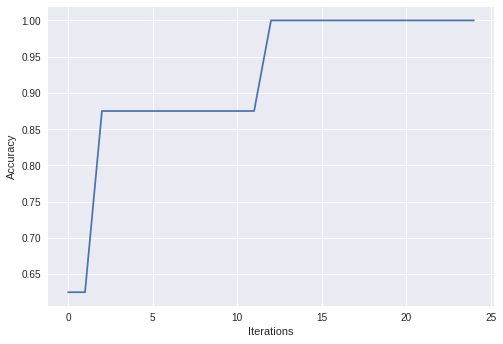

In [36]:
no_of_itr = 25

dti, beta, accuracy_final, beta_j_all, classifiers_all= complete_imp3(no_of_itr,X,test_data,y)

In [37]:
print("Final dti, beta, accuracy_final, beta_j_all")

Final dti, beta, accuracy_final, beta_j_all


In [38]:
beta_j_all

[[-0.18008443866966678, -0.7592949884501276, 0.1807430012034119],
 [0.18963451259627376, -0.5140754736668288, -0.03345633699386615],
 [1.3695399643386958, -0.4251539382954299, -0.5089751911850752],
 [-0.8850525535560657, 0.42515393829542986, 0.45585226922905614],
 [0.277577329890221, 0.31394250331637985, 0.07225458365272512],
 [-0.37106389636823417, 1.0301617281396067, -1.0157541914658184],
 [-0.08145394734433434, -0.7435726609636626, 0.425072640452865],
 [0.03163594811285035, 0.09743900232597169, -0.4251539382954299],
 [-0.07966091472377052, -0.2139285787924611, 1.0157541914658184],
 [0.20727851236901154, -0.18275268794565808, -0.5465824280160837],
 [0.23619440999659208, -0.20977128722219995, 0.0],
 [0.0006776023359544995, 0.18275268794565805, 0.15214867701422155],
 [-1.6424306467797296, 1.4435772097176558, -0.06367598914471817],
 [-1.1701513020112504, 1.0786028109439534, 0.13700378747439929],
 [0.35260066348867153, -0.1111674695948048, -0.18275268794565808],
 [-1.7731099960383654, 1.

In [39]:
print(dti)
print(beta)
print(accuracy_final)
print(beta_j_all)

[[0.10433122939221477, 0.1497634034509512, 0.14966480735392346, 0.10433122939221477, 0.10439996066042703, 0.10433122939221477, 0.1497634034509512, 0.05849953168681474], [0.10788081717480885, 0.14483575865653137, 0.12381192290099666, 0.10788081717480885, 0.12619947767465148, 0.10788081717480885, 0.14483575865653137, 0.03498583534637989], [0.02742588042773853, 0.08706240934941838, 0.20597171521086122, 0.02742588042773853, 0.0758599304958163, 0.02742588042773853, 0.08706240934941838, 0.022869161346296286], [0.017927452020409775, 0.035930001999334917, 0.13056701049198344, 0.06645597260507172, 0.11967035119456416, 0.06645597260507172, 0.035930001999334917, 0.036076497196202435], [0.013097097845367396, 0.038622199990057574, 0.09891978364125295, 0.061823594440053906, 0.1579562694623994, 0.061823594440053906, 0.038622199990057574, 0.04761838546891216], [0.004674998954024933, 0.013986226850227379, 0.14336203609677298, 0.02206788425601825, 0.10898980249870846, 0.02206788425601825, 0.013986226850

# Testing accuracy

In [40]:
def testing(classifiers, Beta_j,X,y, No_of_itr, no_of_Q):
    '''
    here beta_j is the function which is contains the betas in the form - [[beta0,beta1,beta2]itr=1,[beta0,beta1,beta2]itr=2,[beta0,beta1,beta2]itr=3....]
    
    '''

    ## now all the clustering models are stored in classifiers
    
#     X = X_train
#     y = y_train
    
    ## getting y_mod
    T = No_of_itr
    #change labels from 0,1 to -1,1
    y_mod = []
    for i in range(len(y)):
        if y[i]==0:
            y_mod.append(-1)
        else:
            y_mod.append(1)
    
    ## lets do the partitioning to produce domains
    Dti = np.full(len(X),1/len(X))
    
    Beta_js = []# the array which will store all the betas
    accuracy_final_test= []
    for i in range(T):
        beta_j = Beta_j[i]
        predst = classifiers[i].predict(X)
        print(predst)
        final_beta =[]
        # updation of dti and distribution of betas
        for i in range(8):
            if(predst[i]==0):
                final_beta.append(beta_j[0])

            elif(predst[i]==1):
                final_beta.append(beta_j[1])

            else:
                final_beta.append(beta_j[2])
            
        Beta_js.append(final_beta)
            
            # now lets add up the betas and get H(x)
#         print(len())
        final_bin, acc = final_bin_predictions(X,y_mod,Dti,Beta_js)
        accuracy_final_test.append(acc)
            
#     print(Beta_js)
    import matplotlib.pyplot as plt
    from matplotlib import style
    
    plt.style.use('seaborn')
    plt.plot(list(range(T)), accuracy_final_test)
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Breast cancer Testing Accuracy M=16")
    plt.show()
        
    return Beta_js, accuracy_final_test

[2 2 2 2 2 2 0 0]
[0 0 2 2 2 2 0 0]
[2 2 0 0 0 2 1 2]
[0 2 0 0 1 0 2 2]
[2 2 1 2 1 2 0 0]
[0 0 1 1 1 1 0 0]
[0 0 2 2 2 2 1 1]
[1 1 0 0 0 0 1 1]
[0 0 2 2 2 2 1 1]
[0 0 2 2 2 2 0 0]
[1 1 0 0 2 0 1 1]
[2 2 0 0 1 0 2 2]
[1 1 2 2 2 2 0 0]
[0 0 1 1 1 0 2 2]
[0 0 1 1 1 1 0 0]
[1 1 2 2 2 2 0 0]
[2 2 0 0 1 2 2 2]
[1 2 1 1 1 1 2 2]
[1 2 1 1 1 1 2 2]
[2 2 2 2 2 2 0 0]
[2 2 1 1 1 1 2 2]
[2 2 1 0 1 0 2 2]
[0 0 1 1 1 1 0 0]
[2 2 2 2 0 2 1 1]
[2 2 1 1 1 1 2 2]


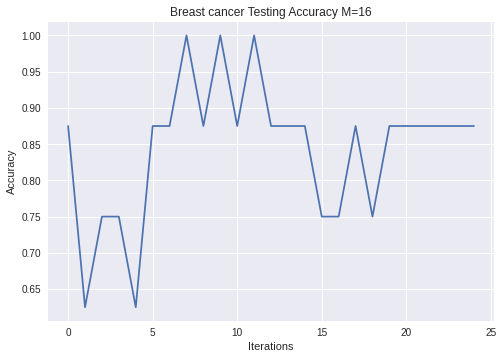

In [56]:
no_of_Q =  4

Beta_js,accuracy_final_test = testing(classifiers_all, beta_j_all,X_test,y_test, no_of_itr, no_of_Q)

In [55]:
print("accuracy_final", accuracy_final)

accuracy_final [0.625, 0.625, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [57]:
print(Beta_js)
print(accuracy_final_test)

[[0.1807430012034119, 0.1807430012034119, 0.1807430012034119, 0.1807430012034119, 0.1807430012034119, 0.1807430012034119, -0.18008443866966678, -0.18008443866966678], [0.18963451259627376, 0.18963451259627376, -0.03345633699386615, -0.03345633699386615, -0.03345633699386615, -0.03345633699386615, 0.18963451259627376, 0.18963451259627376], [-0.5089751911850752, -0.5089751911850752, 1.3695399643386958, 1.3695399643386958, 1.3695399643386958, -0.5089751911850752, -0.4251539382954299, -0.5089751911850752], [-0.8850525535560657, 0.45585226922905614, -0.8850525535560657, -0.8850525535560657, 0.42515393829542986, -0.8850525535560657, 0.45585226922905614, 0.45585226922905614], [0.07225458365272512, 0.07225458365272512, 0.31394250331637985, 0.07225458365272512, 0.31394250331637985, 0.07225458365272512, 0.277577329890221, 0.277577329890221], [-0.37106389636823417, -0.37106389636823417, 1.0301617281396067, 1.0301617281396067, 1.0301617281396067, 1.0301617281396067, -0.37106389636823417, -0.371063